# Web Scraping for Indeed.com & Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being to able extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range be may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10")

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

In [1]:
pre_URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York"

In [2]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd

In [3]:
pre_indeed = requests.get(pre_URL)

In [4]:
pre_soup = BeautifulSoup(pre_indeed.content, "lxml")

Run cell below to see what text-only results look like:

In [137]:
#pre_count = 0
#for i in pre_soup.findAll('div', class_ = '  row result'):
#    print pre_count, i.text
#    print '\n'
#    pre_count += 1

### Write 4 functions to extract each item: location, company, job, and salary.

example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- Make sure these functions are robust and can handle cases where the data/field may not be available.
- Test the functions on the results above

In [6]:
def get_jobtitle(result):
    '''This function constructs a list containing each job title.'''
    jobtitle_list = []
    for i in result.findAll('a', class_ = 'jobtitle turnstileLink'): 
        jobtitle_list.append(str(i.text.encode('utf8')))
    return jobtitle_list

def get_location(result):
    '''This function constructs a list containing each job location.'''
    location_list = []
    for i in result.findAll('span', class_ = 'location'):
        location_list.append(str(i.text.encode('utf8')))
    return location_list

def get_company(result):   
    '''This function constructs a list containing each job company.'''
    company_list = []
    for i in result.findAll('span', class_ = 'company'):
        company = str(i.text.encode('utf8'))
        company = company.replace('\n', '')
        company = company.replace('    ', '')
        company_list.append(company)
    return company_list
    
def get_salary(result):
    '''This function constructs a list containing each job salary.'''
    salary_list = []
    for i in result.findAll('td', class_ = 'snip'):
        if i.find('nobr') != None:
            salary_list.append(i.find('nobr').text)
        else:
            salary_list.append('NaN')
    return salary_list

def putitalltogether(result):
    '''This function creates a dataframe whose columns are the lists produced by the functions it contains.'''
    jobs = get_jobtitle(result)
    locations = get_location(result)
    companies = get_company(result)
    salaries = get_salary(result)
    return pd.DataFrame(zip(jobs, locations, companies, salaries),\
                        columns = ['title', 'location', 'company', 'salary']) 

Let's see what putitalltogether does with pre_soup:

In [7]:
putitalltogether(pre_soup)

,title,location,company,salary
0,Junior Data Scientist,"New York, NY",UncommonGoods,NaN
1,Data Scientist & Analytics Developer,"Long Beach, NY",Lancer Insurance Company,NaN
2,Data Scientist – Predictive Analytics,"New York, NY",Gallup,NaN
3,"Sr. Data Scientist, Learning Services","New York, NY",Brilliant Leap,$800 a day
4,Data Scientist,"New York, NY",Komodo Health,NaN


Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

#### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different

Let's scrape Indeed.com 'Data Science' job listings in the top 25 most populous cities in the United States (https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population) and further narrow the search to full-time jobs.  Let's also increase maximum number of search results per city to 500.

In [8]:
url_template = ['http://www.indeed.com/jobs?q=data+scientist&l=', '&jt=fulltime&start=']

max_results_per_city = 1000

# Create empty dataframe with the columns we want; concatenate to it the new one generated for each city
df = pd.DataFrame(columns=['title', 'location', 'company', 'salary', 'city', 'state'])

for city in set(['New+York,+NY', 'Los+Angeles,+CA', 'Chicago,+IL', 'Houston,+TX', 'Philadelphia,+PA', 'Phoenix,+AZ', \
'San+Antonio,+TX', 'San+Diego,+CA', 'Dallas,+TX', 'San+Jose,+CA', 'Austin,+TX', 'Jacksonville,+FL', 'San+Francisco,+CA',\
'Indianapolis,+IN', 'Columbus,+OH', 'Fort+Worth,+TX', 'Charlotte,+NC', 'Seattle,+WA', 'Denver,+CO', 'El+Paso,+TX', \
'Detroit,+MI', 'Washington,+DC', 'Boston,+MA', 'Memphis,+TN', 'Nashville,+TN']):
    for start in range(0, max_results_per_city, 10):
        # Grab the results from the request (as above)
        URL = url_template[0] + city + url_template[1] + str(start)
        indeed = requests.get(URL)
        soup = BeautifulSoup(indeed.content, "lxml")
        # Append to the full set of results and 
        x = putitalltogether(soup)
        nice_city = city.split(',')
        state = nice_city[1]
        state = state.replace('+', '')
        nice_city = nice_city[0]
        nice_city = nice_city.replace('+', ' ')
        x['city'] = nice_city
        x['state'] = state
        df = pd.concat([x, df], axis = 0)          

Each city's dataframe has its own index which remains unchanged following concatenation, so let's reset the main index now:

In [9]:
df = df.reset_index(drop = True)

Make sure the dataframe appears to be what we're expecting...

In [10]:
len(df)

18151

In [11]:
df.head()

,title,location,company,salary,city,state
0,Principal Technology Product Manager,"Detroit, MI",Amazon,NaN,Detroit,MI
1,Product Development Chemist,"Auburn Hills, MI",Huntsman,NaN,Detroit,MI
2,Senior NEPA Environmental Scientist (Omaha / L...,"Troy, MI",Altair Engineering,NaN,Detroit,MI
3,Data Scientist/Analyst,"Detroit, MI",St John Hospital & Medical Center,NaN,Detroit,MI
4,Radar Exploitation Scientist,"Novi, MI 48375",Antea®Group,NaN,Detroit,MI


In [12]:
df.dtypes

title       object
location    object
company     object
salary      object
city        object
state       object
dtype: object

Keep a copy before we change anything, just in case!  Then we won't have to rescrape for most fixes.

In [13]:
df_copy = df.copy()

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

Already done above by putitalltogether()!

Lastly, we need to clean up salary data. 
1. Some of the salaries are not yearly but hourly, these will be useful to us for now
2. The salaries are given as text and usually with ranges.

#### Filter out the salaries that are not yearly (filter those that refer to hour)

What do the non-'NaN' entries look like?

In [14]:
print 'Of %s' %len(df) +' listings, %s' %len(df[df['salary'] != 'NaN']) +' have non-\'NaN\' salary entries \
(%s percent.)' %(100*float(len(df[df['salary'] != 'NaN']))/len(df))

Of 18151 listings, 595 have non-'NaN' salary entries (3.27805630544 percent.)


In [15]:
print 'Of those: \n\n%s' %len(df[df['salary'].str.contains('month')]) +' are per month; \n%s are per hour;'\
%len(df[df['salary'].str.contains('hour')]) +'\n%s are per day. \n\nDelete these.' \
%len(df[df['salary'].str.contains('day')])


Of those: 

97 are per month; 
99 are per hour;
1 are per day. 

Delete these.


In [16]:
df = df[df['salary'].str.contains('month') == False]
df = df[df['salary'].str.contains('hour') == False]
df = df[df['salary'].str.contains('day') == False]

In [17]:
print 'Of %s' %len(df[df['salary'] != 'NaN']) +' non-\'NaN\' salary entries, %s' \
%len(df[df['salary'].str.contains('year')]) +' are explicitly labeled as yearly.'

Of 398 non-'NaN' salary entries, 398 are explicitly labeled as yearly.


The following cell notifies whether any remaining non-'NaN' salary entries are not explicitly labeled as yearly (otherwise we can assume that they are):

In [18]:
if (-len(df[df['salary'].str.contains('year')]) + (len(df[df['salary'] != 'NaN']))) != 0:
    print 'The %s' %(-len(df[df['salary'].str.contains('year')]) + (len(df[df['salary'] != 'NaN']))) +' which are not \
explicitly labeled as yearly salaries are the following:'
    df[(df['salary'] != 'NaN') & (df['salary'].str.contains('year') == False)]
else:
    print 'All remaining non-\'Nan\' salary entries are explicitly labeled as yearly.'

All remaining non-'Nan' salary entries are explicitly labeled as yearly.


In [19]:
type(df[df['salary'] != 'NaN']['salary'])

pandas.core.series.Series

In [20]:
def num_cat(x):
    cat_list = []
    for i in x:
        cat_list.append(type(i))
    return set(cat_list)

In [21]:
num_cat(df['salary'])

{str, unicode}

#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary

In [22]:
def parse_salary(df):
    '''This function takes a dataframe argument containing a column 'salary' and creates a new column, \
    'parsed_salary', with corresponding float entries (which are the average of a range, if and when provided).'''
    parsed_salary = []
    for i in df['salary']:
        if i == 'NaN':
            parsed_salary.append(i)
        elif i != 'NaN':
            x = str(i)
            if '-' in x:
                x = x.split('-')
                x[0] = x[0].replace('$', '')
                x[0] = x[0].replace(',', '')
                x[0] = x[0].replace(' ', '')
                x[1] = x[1].replace('$', '')
                x[1] = x[1].replace(',', '')
                x2 = x[1].split(' ')
                x[1] = x2[1]
                new_x = (float(x[0]) + float(x[1]))/2
                parsed_salary.append(new_x)   
            elif '$' in x:
                z = x.split(' ')
                z = z[0]
                z = z.replace('$', '')
                z = z.replace(',', '')
                parsed_salary.append(float(z))
            else:
                parsed_salary.append('delete_me')
    df['parsed_salary'] = parsed_salary
    df = df[df['parsed_salary'].str.contains('delete_me') == False]
    return 

Examine modified dataframe to ensure 'city', 'state', and 'parsed_salary' columns appear:

In [23]:
parse_salary(df)
df.head()

,title,location,company,salary,city,state,parsed_salary
0,Principal Technology Product Manager,"Detroit, MI",Amazon,NaN,Detroit,MI,NaN
1,Product Development Chemist,"Auburn Hills, MI",Huntsman,NaN,Detroit,MI,NaN
2,Senior NEPA Environmental Scientist (Omaha / L...,"Troy, MI",Altair Engineering,NaN,Detroit,MI,NaN
3,Data Scientist/Analyst,"Detroit, MI",St John Hospital & Medical Center,NaN,Detroit,MI,NaN
4,Radar Exploitation Scientist,"Novi, MI 48375",Antea®Group,NaN,Detroit,MI,NaN


See what non-'NaN' 'parsed_salary' entries look like:

In [24]:
df[df['parsed_salary'] != 'NaN'].head()

,title,location,company,salary,city,state,parsed_salary
571,Data Scientist – Predictive Analytics,"Cambridge, MA",U.S. Federal Government,"$92,448 - $142,021 a year",Boston,MA,117234
615,Data Scientist – Predictive Analytics,"Burlington, MA",Workbridge Associates,"$100,000 - $145,000 a year",Boston,MA,122500
631,Quantitative Data Analyst,"Natick, MA",Execu | Search,"$140,000 - $160,000 a year",Boston,MA,150000
645,"Engineer III/Sr Assoc Scientist, Protein Formu...","Waltham, MA",Strategic Employment Partners,"$50,000 - $65,000 a year",Boston,MA,57500
651,Data Scientist – Predictive Analytics,"Cambridge, MA",Penfield Search Partners,"$150,000 a year",Boston,MA,150000


### Save your results as a CSV

In [26]:
df.to_csv('IndeedSalaryData.csv', encoding='utf-8')

## Predicting salaries using Logistic Regression

#### Load in the data of scraped salaries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import plotly as py
from collections import Counter
import re
% matplotlib inline

# Make the plots bigger
plt.rcParams['figure.figsize'] = 10, 10
import seaborn as sns

import numpy as np
import statsmodels.api as st
import sklearn
from sklearn import linear_model as lm
from sklearn import datasets, cross_validation, pipeline, preprocessing, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix

In [2]:
df_new = pd.read_csv('/Users/Rebecca/DSI-projects/projects/project-04/starter-code/IndeedSalaryData.csv')
df_new = df_new[['title', 'location', 'company', 'city', 'state', 'parsed_salary']]
df_new.head()

,title,location,company,city,state,parsed_salary
0,Principal Technology Product Manager,"Detroit, MI",Amazon,Detroit,MI,NaN
1,Product Development Chemist,"Auburn Hills, MI",Huntsman,Detroit,MI,NaN
2,Senior NEPA Environmental Scientist (Omaha / L...,"Troy, MI",Altair Engineering,Detroit,MI,NaN
3,Data Scientist/Analyst,"Detroit, MI",St John Hospital & Medical Center,Detroit,MI,NaN
4,Radar Exploitation Scientist,"Novi, MI 48375",Antea®Group,Detroit,MI,NaN


Create a new dataframe which contains only observations whose 'parsed_salary' entries are numerical:

In [3]:
sal_df = df_new[df_new['parsed_salary'] >= 0]

In [4]:
print 'The minimum listed salary is %s' %min(sal_df['parsed_salary'])
sal_df[sal_df['parsed_salary'] == min(sal_df['parsed_salary'])]

The minimum listed salary is 35000.0


,title,location,company,city,state,parsed_salary
6318,Data Scientist,"Austin, TX 78746",Myriad Development,Austin,TX,35000.0


In [5]:
print 'The maximum listed salary is %s' %max(sal_df['parsed_salary'])
sal_df[sal_df['parsed_salary'] == max(sal_df['parsed_salary'])]

The maximum listed salary is 250000.0


,title,location,company,city,state,parsed_salary
8361,Software Development Engineer – New AWS Machin...,"Philadelphia, PA",Averity,Philadelphia,PA,250000.0


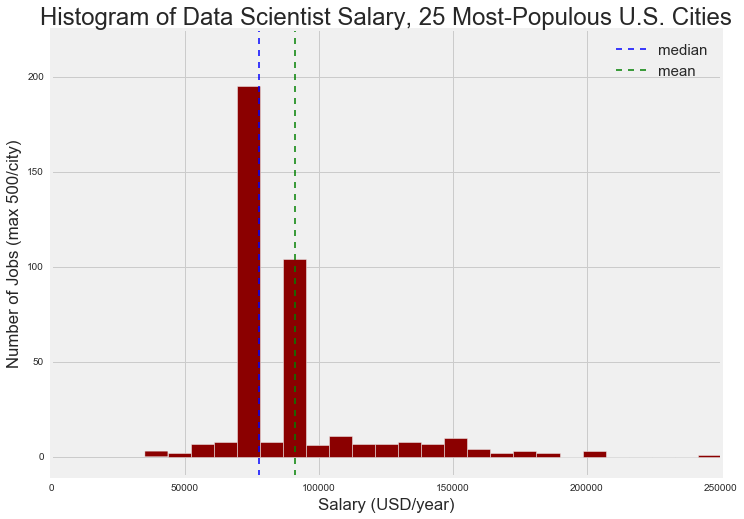

In [6]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

df_hist = plt.hist(sal_df['parsed_salary'], color = 'darkred', bins = 25)
plt.axvline(sal_df['parsed_salary'].median(), color='b', linestyle='dashed', linewidth=1.5, label = 'median')
plt.axvline(sal_df['parsed_salary'].mean(), color='g', linestyle='dashed', linewidth=1.5, label = 'mean')

plt.title('Histogram of Data Scientist Salary, 25 Most-Populous U.S. Cities', fontsize = 24)

# y label
plt.ylabel('Number of Jobs (max 500/city)')

# x label
plt.xlabel('Salary (USD/year)')

plt.xlim([0, max(sal_df['parsed_salary'])])
plt.ylim([-10, 225])

plt.legend(loc='upper right', fontsize = 15)

plt.show()

#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median)

In [7]:
median = float(sal_df['parsed_salary'].describe().loc['50%'])
print 'The median salary is %s.' %median

The median salary is 77500.0.


In [8]:
def sal_dummify(x):
    sal_dummy = []
    for i in sal_df['parsed_salary']:
        if i > median:
            sal_dummy.append(1)
        elif i <= median:
            sal_dummy.append(0)
        # This shouldn't happen
        else:
            sal_dummy.append('NaN')
    x['sal_dummy'] = sal_dummy
    return x

In [9]:
sal_dummify(sal_df)
sal_df['sal_dummy'].value_counts()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



0    215
1    183
Name: sal_dummy, dtype: int64

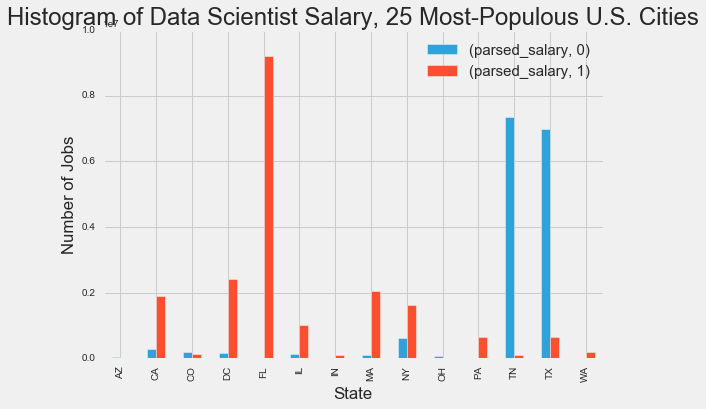

In [10]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

new = sal_df.groupby(['state','sal_dummy']).sum().unstack()

new.plot.bar()

plt.title('Histogram of Data Scientist Salary, 25 Most-Populous U.S. Cities', fontsize = 24)

# y label
plt.ylabel('Number of Jobs')

# x label
plt.xlabel('State')

plt.legend(loc='upper right', fontsize = 15)

plt.show()

#### Create a Logistic Regression model to predict High/Low salary using statsmodel. Start by ONLY using the location as a feature. Display the coefficients and write a short summary of what they mean.

First, do a logistic regression with dummy variables according to cities:

In [11]:
print 'There are %s distinct cities represented in the dataframe.' %len(sal_df['city'].unique())
sal_df['city'].value_counts()

There are 21 distinct cities represented in the dataframe.


Jacksonville     98
Memphis          97
Houston          88
Washington       25
New York         19
Boston           18
Chicago          10
San Francisco     9
San Jose          6
Dallas            4
Denver            4
Philadelphia      4
Los Angeles       3
San Antonio       3
San Diego         2
Seattle           2
Austin            2
Phoenix           1
Columbus          1
Nashville         1
Indianapolis      1
Name: city, dtype: int64

In [12]:
X_city = pd.DataFrame(sal_df['city'])
X_city['intercept'] = 1
X_city = pd.concat([X_city.drop('city',axis=1), pd.get_dummies(X_city['city'])], axis = 1)
y = sal_df['sal_dummy']

In [13]:
X_city.head(1)

,intercept,Austin,Boston,Chicago,Columbus,Dallas,Denver,Houston,Indianapolis,Jacksonville,...,Nashville,New York,Philadelphia,Phoenix,San Antonio,San Diego,San Francisco,San Jose,Seattle,Washington
571,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Drop one of the dummy variables (just pick first one on the left):

In [14]:
X_city.drop('Austin', axis=1, inplace=True)

In [15]:
model_city = st.MNLogit(y, X_city)

In [16]:
model_city_fit = model_city.fit(method = 'bfgs')

         Current function value: 0.147749
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


//anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [17]:
model_city_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              sal_dummy   No. Observations:                  398
Model:                        MNLogit   Df Residuals:                      377
Method:                           MLE   Df Model:                           20
Date:                Thu, 07 Jul 2016   Pseudo R-squ.:                  0.7858
Time:                        08:58:43   Log-Likelihood:                -58.804
converged:                      False   LL-Null:                       -274.58
                                        LLR p-value:                 5.655e-79
=================================================================================
  sal_dummy=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
intercept         0.5190      1.462      0.355      0.723        -2.347     3.385
Boston            1.8201      1.682      1.082      0.279        -1.477     5.117
Chicago           1.1423      1.698      0.673      0.501        -2.186     4.470
Columbus         -1.1944      2.571     -0.465      0.642        -6.234     3.845
Dallas           -0.6612      1.773     -0.373      0.709        -4.136     2.813
Denver           -2.0133      1.951     -1.032      0.302        -5.838     1.811
Houston          -5.1862      1.836     -2.825      0.005        -8.784    -1.588
Indianapolis      0.8114      2.861      0.284      0.777        -4.796     6.418
Jacksonville      7.6482      6.173      1.239      0.215        -4.451    19.748
Los Angeles       1.9531      2.604      0.750      0.453        -3.151     7.057
Memphis          -7.3532      3.426     -2.146      0.032       -14.068    -0.639
Nashville         0.8114      2.861      0.284      0.777        -4.796     6.418
New York         -0.3420      1.533     -0.223      0.823        -3.346     2.663
Philadelphia      2.3675      2.671      0.886      0.375        -2.868     7.602
Phoenix          -1.1944      2.571     -0.465      0.642        -6.234     3.845
San Antonio      -1.2986      1.919     -0.677      0.499        -5.061     2.463
San Diego        -0.3729      2.037     -0.183      0.855        -4.365     3.619
San Francisco     2.1668      1.999      1.084      0.278        -1.752     6.085
San Jose         -0.8643      1.681     -0.514      0.607        -4.158     2.430
Seattle           1.4457      2.603      0.555      0.579        -3.656     6.547
Washington        1.2471      1.568      0.795      0.426        -1.826     4.320
=================================================================================
"""

In [18]:
### aic and bic ###
print 'AIC: %s' %model_city_fit.aic
print 'BIC: %s' %model_city_fit.bic

AIC: 159.608285319
BIC: 243.32377743


In [19]:
### marginal effects ###
#model_city_margeff = model_city_fit.get_margeff()
#print model_city_margeff.summary() 

Houston and Memphis dummy variables are significant in this model at a 0.05 significance level.

Now, do a logistic regression with dummy variables according to states:

In [20]:
print 'There are %s distinct states represented in the dataframe.' %len(sal_df['state'].unique())
sal_df['state'].value_counts()

There are 14 distinct states represented in the dataframe.


TN    98
FL    98
TX    97
DC    25
CA    20
NY    19
MA    18
IL    10
PA     4
CO     4
WA     2
OH     1
AZ     1
IN     1
Name: state, dtype: int64

In [21]:
X_state = pd.DataFrame(sal_df['state'])
X_state['intercept'] = 1
X_state = pd.concat([X_state.drop('state',axis=1), pd.get_dummies(X_state['state'])], axis = 1)
y = sal_df['sal_dummy']

In [22]:
X_state.head(1)

,intercept,AZ,CA,CO,DC,FL,IL,IN,MA,NY,OH,PA,TN,TX,WA
571,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Drop one of the dummy variables (just pick first one on the left):

In [23]:
X_state.drop('AZ', axis=1, inplace=True)

In [24]:
model_state = st.MNLogit(y, X_state)

In [25]:
model_state_fit = model_state.fit(method = 'bfgs')

         Current function value: 0.189293
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


//anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [26]:
model_state_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              sal_dummy   No. Observations:                  398
Model:                        MNLogit   Df Residuals:                      384
Method:                           MLE   Df Model:                           13
Date:                Thu, 07 Jul 2016   Pseudo R-squ.:                  0.7256
Time:                        08:58:52   Log-Likelihood:                -75.339
converged:                      False   LL-Null:                       -274.58
                                        LLR p-value:                 4.656e-77
===============================================================================
sal_dummy=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
intercept       0.5767      2.084      0.277      0.782        -3.507     4.661
CA              0.3264      2.141      0.152      0.879        -3.871     4.523
CO             -1.6724      2.382     -0.702      0.483        -6.341     2.996
DC              1.3990      2.172      0.644      0.519        -2.857     5.655
FL              6.2126      3.664      1.695      0.090        -0.969    13.395
IL              0.9107      2.238      0.407      0.684        -3.475     5.296
IN              0.5503      3.123      0.176      0.860        -5.570     6.671
MA              1.7106      2.237      0.765      0.445        -2.675     6.096
NY             -0.5027      2.134     -0.236      0.814        -4.685     3.679
OH             -0.9202      2.909     -0.316      0.752        -6.621     4.781
PA              1.6815      2.694      0.624      0.533        -3.599     6.962
TN             -5.6749      2.456     -2.310      0.021       -10.489    -0.861
TX             -3.4307      2.131     -1.610      0.107        -7.608     0.746
WA              0.9984      2.804      0.356      0.722        -4.497     6.494
===============================================================================
"""

In [27]:
### aic and bic ###
print 'AIC: %s' %model_state_fit.aic
print 'BIC: %s' %model_state_fit.bic

AIC: 178.677070852
BIC: 234.487398926


In [28]:
### marginal effects ###
#model_state_margeff = model_state_fit.get_margeff()
#print model_state_margeff.summary() 

The TN dummy variable is significant in this model at a 0.05 significance level.

#### Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' is in the title 
- or whether 'Manager' is in the title. 
- Then build a new Logistic Regression model with these features. Do they add any value? 


In [29]:
sal_df.head(1)

,title,location,company,city,state,parsed_salary,sal_dummy
571,Data Scientist – Predictive Analytics,"Cambridge, MA",U.S. Federal Government,Boston,MA,117234.5,1


Make a list of (non-unique) terms found in 'title' entries; ignore case and symbols.

In [30]:
all_terms = []
for i in sal_df['title']:
    x = i.lower()
    x = re.sub(r'[^\w]', ' ', x)
    x = x.split(' ')
    all_terms = all_terms + x
    
unique_terms = list(set(all_terms))

Figure out which of these terms appear the most frequently in the dataframe:

In [31]:
term_counts = []
for i in unique_terms:
    count = all_terms.count(i)
    term_counts.append(count)

count_df = pd.DataFrame([unique_terms, term_counts]).T
count_df.columns = ['term', 'count']

In [32]:
count_df.sort('count', ascending = False).head(50)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



,term,count
0,,1658
5,scientist,206
68,engineer,159
109,data,154
58,software,139
101,development,138
99,machine,133
104,aws,117
65,learning,105
39,re,89


In [33]:
def titleify(df):
    titles = []
    for i in df['title']:
        x = i.lower()
        x = re.sub(r'[^\w]', ' ', x)
        titles.append(x)
    df['nice_titles'] = titles
    return df

In [34]:
titleify(sal_df)
sal_df.head(1)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,title,location,company,city,state,parsed_salary,sal_dummy,nice_titles
571,Data Scientist – Predictive Analytics,"Cambridge, MA",U.S. Federal Government,Boston,MA,117234.5,1,data scientist predictive analytics


In [35]:
terms = ['senior', 'sr', 'principal', 'officer', 'expert', 'manager', 'relocation']

In [36]:
sal_df = sal_df.reset_index(drop = True)

In [37]:
sal_df['senior'] = sal_df['nice_titles'].str.extract('(senior)')
sal_df['sr'] = sal_df['nice_titles'].str.extract('(sr)')
sal_df['principal'] = sal_df['nice_titles'].str.extract('(principal)')
sal_df['officer'] = sal_df['nice_titles'].str.extract('(officer)')
sal_df['expert'] = sal_df['nice_titles'].str.extract('(expert)')
sal_df['manager'] = sal_df['nice_titles'].str.extract('(manager)')
sal_df['relocation'] = sal_df['nice_titles'].str.extract('(relocation)')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning:

currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning:

currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning:

currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning:

currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFram

In [38]:
sal_df.head(1)

,title,location,company,city,state,parsed_salary,sal_dummy,nice_titles,senior,sr,principal,officer,expert,manager,relocation
0,Data Scientist – Predictive Analytics,"Cambridge, MA",U.S. Federal Government,Boston,MA,117234.5,1,data scientist predictive analytics,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
senior = []
for i in sal_df['senior']:
    if i == 'senior':
        senior.append(1)
    else:
        senior.append(0)
sal_df['senior'] = senior

sr = []
for i in sal_df['sr']:
    if i == 'sr':
        sr.append(1)
    else:
        sr.append(0)
sal_df['sr'] = sr

principal = []
for i in sal_df['principal']:
    if i == 'principal':
        principal.append(1)
    else:
        principal.append(0)
sal_df['principal'] = principal

officer = []
for i in sal_df['officer']:
    if i == 'officer':
        officer.append(1)
    else:
        officer.append(0)
sal_df['officer'] = officer

expert = []
for i in sal_df['expert']:
    if i == 'expert':
        expert.append(1)
    else:
        expert.append(0)
sal_df['expert'] = expert

manager = []
for i in sal_df['manager']:
    if i == 'manager':
        manager.append(1)
    else:
        manager.append(0)
sal_df['manager'] = manager

relocation = []
for i in sal_df['relocation']:
    if i == 'relocation':
        relocation.append(1)
    else:
        relocation.append(0)
sal_df['relocation'] = relocation

In [40]:
sal_df.head(1)

,title,location,company,city,state,parsed_salary,sal_dummy,nice_titles,senior,sr,principal,officer,expert,manager,relocation
0,Data Scientist – Predictive Analytics,"Cambridge, MA",U.S. Federal Government,Boston,MA,117234.5,1,data scientist predictive analytics,0,0,0,0,0,0,0


In [41]:
X_title = pd.DataFrame(sal_df[['senior', 'sr', 'principal', 'officer', 'expert', 'manager', 'relocation']])
X_title['intercept'] = 1
y = sal_df['sal_dummy']

In [42]:
model_title = st.MNLogit(y, X_title)

In [43]:
model_title_fit = model_title.fit(method = 'bfgs')

         Current function value: 0.635475
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


//anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [44]:
model_title_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              sal_dummy   No. Observations:                  398
Model:                        MNLogit   Df Residuals:                      390
Method:                           MLE   Df Model:                            7
Date:                Thu, 07 Jul 2016   Pseudo R-squ.:                 0.07890
Time:                        08:59:30   Log-Likelihood:                -252.92
converged:                      False   LL-Null:                       -274.58
                                        LLR p-value:                 2.879e-07
===============================================================================
sal_dummy=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
senior          1.2399      0.621      1.997      0.046         0.023     2.457
sr              2.2324      1.328      1.682      0.093        -0.369     4.834
principal      -1.0246      2.490     -0.411      0.681        -5.905     3.856
officer         3.9074      2.732      1.430      0.153        -1.448     9.262
expert         -1.5127      1.200     -1.261      0.207        -3.864     0.839
manager        -1.0246      2.490     -0.411      0.681        -5.905     3.856
relocation      3.2345      0.983      3.291      0.001         1.308     5.161
intercept      -0.3453      0.109     -3.164      0.002        -0.559    -0.131
===============================================================================
"""

In [45]:
### aic and bic ###
print 'AIC: %s' %model_title_fit.aic
print 'BIC: %s' %model_title_fit.bic

AIC: 521.838465997
BIC: 553.730082039


In [46]:
### marginal effects ###
model_title_margeff = model_title_fit.get_margeff()
print model_title_margeff.summary()

       MNLogit Marginal Effects      
Dep. Variable:              sal_dummy
Method:                          dydx
At:                           overall
sal_dummy=0      dy/dx    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
senior         -0.2786      0.137     -2.039      0.041        -0.546    -0.011
sr             -0.5016      0.295     -1.702      0.089        -1.079     0.076
principal       0.2302      0.559      0.412      0.681        -0.866     1.326
officer        -0.8779      0.610     -1.439      0.150        -2.074     0.318
expert          0.3399      0.268      1.268      0.205        -0.185     0.865
manager         0.2302      0.559      0.412      0.681        -0.866     1.326
relocation     -0.7268      0.213     -3.419      0.001        -1.143    -0.310
-------------------------------------------------------------------------------
sal_dummy=1      dy/dx    std err          z    

According to this model, we see that 'senior,' 'sr,' 'relocation,' and the intercept are significant at a 0.05 level.

In [47]:
X_big = pd.DataFrame(zip(sal_df['senior'], sal_df['sr'], sal_df['relocation'], X_city['Houston'], X_city['Memphis'],\
                      X_state['TN']))
X_big.columns = ['senior', 'sr', 'relocation', 'Houston', 'Memphis', 'TN']
X_big['intercept'] = 1
y = sal_df['sal_dummy']

In [48]:
model_big = st.MNLogit(y, X_big)

In [49]:
model_big_fit = model_big.fit(method = 'bfgs')

         Current function value: 0.234665
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


//anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [50]:
model_big_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              sal_dummy   No. Observations:                  398
Model:                        MNLogit   Df Residuals:                      391
Method:                           MLE   Df Model:                            6
Date:                Thu, 07 Jul 2016   Pseudo R-squ.:                  0.6599
Time:                        08:59:36   Log-Likelihood:                -93.397
converged:                      False   LL-Null:                       -274.58
                                        LLR p-value:                 3.397e-75
===============================================================================
sal_dummy=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
senior          0.5165      1.067      0.484      0.628        -1.575     2.608
sr             -0.3526      1.117     -0.316      0.752        -2.542     1.837
relocation      2.2770      1.659      1.372      0.170        -0.975     5.529
Houston        -5.9686      0.946     -6.308      0.000        -7.823    -4.114
Memphis        -4.8574      3.557     -1.365      0.172       -11.830     2.115
TN             -3.0091      2.770     -1.086      0.277        -8.438     2.420
intercept       1.6777      0.206      8.130      0.000         1.273     2.082
===============================================================================
"""

There is a faster way to test pairwise correlations:

In [51]:
print np.corrcoef(X_big['senior'], X_big['sr'])[0, 1]
print np.corrcoef(X_big['senior'], X_big['relocation'])[0, 1]
print np.corrcoef(X_big['senior'], X_big['Houston'])[0, 1]
print np.corrcoef(X_big['senior'], X_big['Memphis'])[0, 1]
print np.corrcoef(X_big['senior'], X_big['TN'])[0, 1]
print np.corrcoef(X_big['senior'], X_big['Houston'])[0, 1]
print np.corrcoef(X_big['sr'], X_big['relocation'])[0, 1]
print np.corrcoef(X_big['sr'], X_big['Houston'])[0, 1]
print np.corrcoef(X_big['sr'], X_big['Memphis'])[0, 1]
print np.corrcoef(X_big['sr'], X_big['TN'])[0, 1]
print np.corrcoef(X_big['relocation'], X_big['Houston'])[0, 1]
print np.corrcoef(X_big['relocation'], X_big['Memphis'])[0, 1]
print np.corrcoef(X_big['relocation'], X_big['TN'])[0, 1]
print np.corrcoef(X_big['Houston'], X_big['Memphis'])[0, 1]
print np.corrcoef(X_big['Houston'], X_big['TN'])[0, 1]
print np.corrcoef(X_big['Memphis'], X_big['TN'])[0, 1]

-0.0207266941272
-0.043369087412
-0.097904307649
-0.00554247377497
-0.00659499211864
-0.097904307649
-0.0266212043543
-0.0600965050596
-0.0640311565594
-0.0644675457995
-0.125747529494
-0.133980499199
-0.108806314572
-0.302456629718
-0.304517951516
0.993230869352


In [52]:
del X_big['TN']

In [53]:
model_big = st.MNLogit(y, X_big)

In [54]:
model_big_fit = model_big.fit(method = 'bfgs')

         Current function value: 0.232660
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


//anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [55]:
model_big_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              sal_dummy   No. Observations:                  398
Model:                        MNLogit   Df Residuals:                      392
Method:                           MLE   Df Model:                            5
Date:                Thu, 07 Jul 2016   Pseudo R-squ.:                  0.6628
Time:                        08:59:43   Log-Likelihood:                -92.599
converged:                      False   LL-Null:                       -274.58
                                        LLR p-value:                 1.716e-76
===============================================================================
sal_dummy=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
senior          0.4760      1.059      0.449      0.653        -1.600     2.552
sr             -0.2179      1.166     -0.187      0.852        -2.503     2.067
relocation      1.4349      1.105      1.298      0.194        -0.731     3.601
Houston        -6.1431      1.022     -6.013      0.000        -8.145    -4.141
Memphis        -9.2523      4.424     -2.091      0.037       -17.924    -0.581
intercept       1.6879      0.207      8.150      0.000         1.282     2.094
===============================================================================
"""

In [56]:
del X_big['senior']
del X_big['sr']
del X_big['relocation']

#### Rebuild this model with scikit-learn.
- You can either create the dummy features manually or use the `dmatrix` function from `patsy`
- Remember to scale the feature variables as well!


In [57]:
skl_model = lm.LogisticRegression()

features = ['Houston', 'Memphis']

X = X_big[features]
X['intercept'] = 1
y = sal_df['sal_dummy']
#this is a binary column: was the salary over median salary or not?

skl_model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [58]:
X.head()

,Houston,Memphis,intercept
0,0.0,0.0,1
1,0.0,0.0,1
2,0.0,0.0,1
3,0.0,0.0,1
4,0.0,0.0,1


In [59]:
X_big['probability'] = skl_model.predict_proba(X).T[1]

In [60]:
X_big['probability'].head()

0    0.810225
1    0.810225
2    0.810225
3    0.810225
4    0.810225
Name: probability, dtype: float64

In [61]:
predictions = skl_model.predict(X)

cm = confusion_matrix(y, predictions)
cm

array([[184,  31],
       [  1, 182]])

In [62]:
sum(predictions)

213

Therefore, the right-hand entries in the confusion matrix represent the true and false positives (since 182 + 31 = 213).

In [63]:
import matplotlib.patheffects as path_effects

def plot_confusion_matrix(cm, title='Confusion matrix', labels=['Positive','Negative'], cmap=plt.cm.Blues):
    
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
        
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=18).set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                                                       path_effects.Normal()]) #The last line here adds a text outline
    return

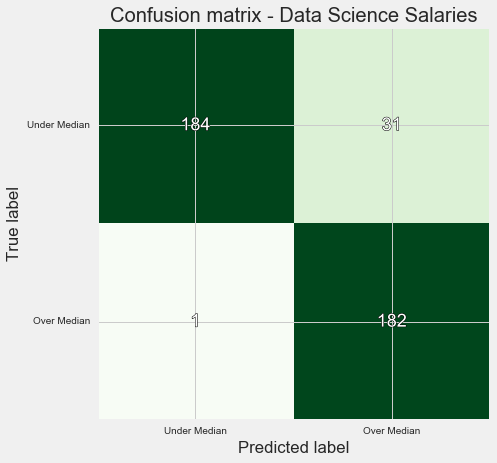

In [64]:
plot_confusion_matrix(cm, title='Confusion matrix - Data Science Salaries', labels=['Under Median','Over Median'], \
                      cmap=plt.cm.Greens)

In [65]:
from sklearn.metrics import roc_curve

roc = roc_curve(y, predictions)
roc

(array([ 0.        ,  0.14418605,  1.        ]),
 array([ 0.        ,  0.99453552,  1.        ]),
 array([2, 1, 0]))

In [66]:
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import train_test_split

pred1 = skl_model.predict_proba(X).T[1]
roc = roc_curve(y, pred1)

def getROCcurve(roc, title='ROC Curve', xlabel ='% of False Positives', ylabel = '% of True Positives'):
    
    fpr, tpr, thresholds = roc
    
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC Curve')

    fig.set_size_inches(7, 6, forward=True)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')
    return

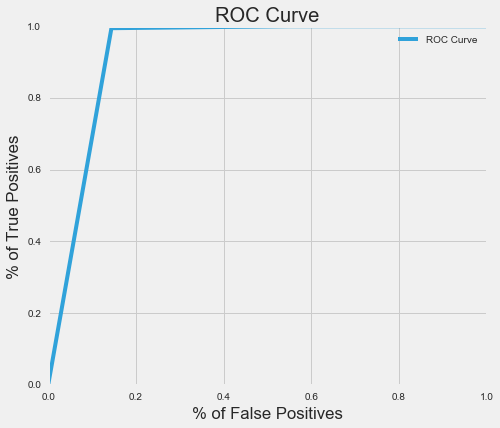

In [67]:
getROCcurve(roc, title='ROC Curve', xlabel ='% of False Positives', ylabel = '% of True Positives')

#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy, AUC, precision and recall of the model. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.

In [68]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc #area under the curve -- which curve?

In [69]:
X.head()

,Houston,Memphis,intercept
0,0.0,0.0,1
1,0.0,0.0,1
2,0.0,0.0,1
3,0.0,0.0,1
4,0.0,0.0,1


In [70]:
cross_val_score(skl_model, X, y, n_jobs=1, cv=5)

array([ 0.8       ,  1.        ,  0.925     ,  0.98734177,  0.88607595])

In [71]:
cross_val_score(skl_model, X, y, n_jobs=1, cv=5).mean()

0.9196835443037974

In [72]:
print 'accuracy: %s' %accuracy_score(y, predictions)
print 'precision: %s' %precision_score(y, predictions)
print 'recall: %s' %recall_score(y, predictions)
print 'area under curve: %s' %roc_auc_score(y, predictions)

accuracy: 0.91959798995
precision: 0.854460093897
recall: 0.994535519126
area under curve: 0.925174736307


Our recall (TP/P) is very good; this means that we are identifying a large proportion of the positives correctly.  On the other hand, our precision (TP/(TP + FP)) is not quite as good, meaning that our model is identifying some false positives along with the nice proportion of true positives.  In our example, some of our salaries are identified as being over the median when they are, in fact, under it.  

#### Compare L1 and L2 regularization for this logistic regression model. What effect does this have on the coefficients learned?

In [127]:
model_l1 = lm.LogisticRegression(penalty = 'l1')

features = ['Houston', 'Memphis']

X_l1 = X_big[features]
X_l1['intercept'] = 1
y = sal_df['sal_dummy']
#this is a binary column: was the salary over median salary or not?

model_l1.fit(X_l1, y)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [128]:
X_big['prob_l1'] = model_l1.predict_proba(X).T[1]

In [129]:
predictions = model_l1.predict(X)

cm = confusion_matrix(y, predictions)
cm

array([[184,  31],
       [  1, 182]])

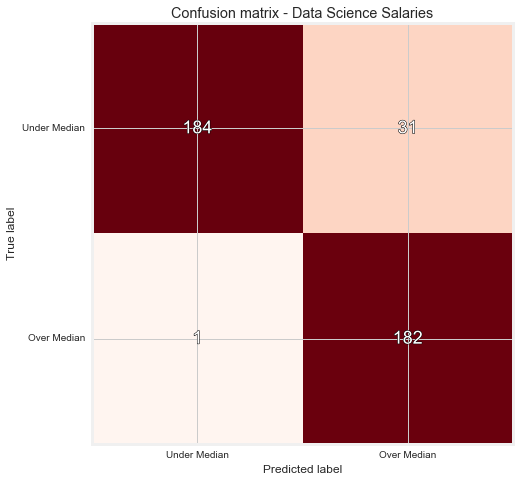

In [131]:
plot_confusion_matrix(cm, title='Confusion matrix - Data Science Salaries', labels=['Under Median','Over Median'], \
                      cmap=plt.cm.Reds)

L2:

In [132]:
model_l2 = lm.LogisticRegression(penalty = 'l2')

features = ['Houston', 'Memphis']

X_l2 = X_big[features]
X_l2['intercept'] = 1
y = sal_df['sal_dummy']
#this is a binary column: was the salary over median salary or not?

model_l2.fit(X_l2, y)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [133]:
X_big['prob_l2'] = model_l2.predict_proba(X).T[1]

In [134]:
predictions = model_l2.predict(X)

cm = confusion_matrix(y, predictions)
cm

array([[184,  31],
       [  1, 182]])

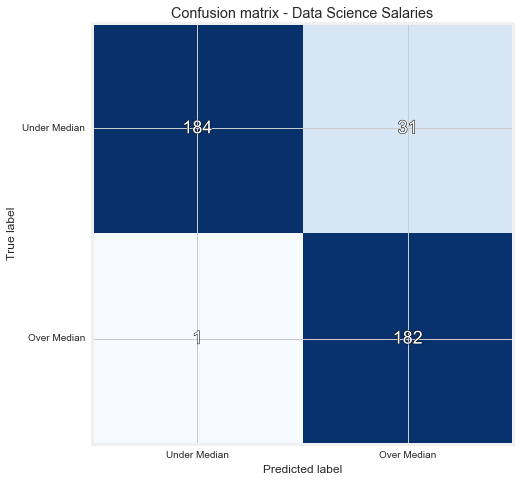

In [136]:
plot_confusion_matrix(cm, title='Confusion matrix - Data Science Salaries', labels=['Under Median','Over Median'], \
                      cmap=plt.cm.Blues)

L1 vs L2 penalty does not seem to make a difference in the predictions of these models; this is perhaps because of the very large proportion of lower-salaried Data Science job results found in Tennessee and Texas.

### BONUS 

#### Bonus: Use Count Vectorizer from scikit-learn to create features from the text summaries. 
- Examine using count or binary features in the model
- Re-evaluate the logistic regression model using these. Does this improve the model performance? 
- What text features are the most valuable? 

In [24]:
## YOUR CODE HERE

#### Re-test L1 and L2 regularization. You can use LogisticRegressionCV to find the optimal reguarlization parameters. 
- Re-test what text features are most valuable.  
- How do L1 and L2 change the coefficients?

In [25]:
## YOUR CODE HERE